In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text
from scipy import stats
import plotly.express as px
import toml
import psrc_theme
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
summary_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'summary_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])
# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

c:\Users\Modeller\AppData\Local\anaconda3\envs\summary\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## transit boarding

### boarding by mode

In [2]:
# Process 2024 observed data
df_obs = pd.read_sql(text("SELECT * FROM observed_transit_boardings"), con=conn.connect())

df_obs["route_id"] = df_obs["route_id"].astype("int")

df_obs = df_obs[df_obs['year'].isin([2023,2024])]

df_obs = pd.pivot_table(df_obs, index='route_id', values='observed_daily', columns='year', aggfunc='sum')
df_obs = df_obs.reset_index()



In [ ]:

# Load model results and calculate modeled daily boarding by line
df_transit_line = pd.read_csv(os.path.join(valid_config['model_dir'], 'outputs/transit/transit_line_results.csv'))
df_model = df_transit_line.copy()
df_model_daily = (
    df_model.groupby(["route_code", "mode",'agency_code'])
    .agg({"description": "first", "boardings": "sum"})
    .reset_index()
)

# Merge modeled with observed boarding data
df_model_daily["route_code"] = df_model_daily["route_code"].astype("int")
df = df_model_daily.merge(
    df_obs, left_on="route_code", right_on="route_id", how="left"
)

df.rename(
    columns={
        "boardings": "Model",
        2023: "2023 Spring Observed",
        2024: "2024 Spring Observed",
    },
    inplace=True,
)


df['agency'] = df['agency_code'].astype('int').astype('str').map(summary_config['agency_lookup'])
df_line_boardings_23_24 = df.copy()

In [53]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_mode.csv')).sort_values('model_boardings', ascending=False)
table_df = df.copy()
table_df['mode_name'] = table_df['mode'].map({'c':'Commuter Rail','b':'Bus','r':'Rail','f':'Ferry (1)','p':'Ferry (2)'})
# table_df[['mode','mode_name','model_boardings','2023','2024']]
table_df.rename(
    columns={
        "model_boardings": "Model",
        "2023": "2023 Spring Observed",
        "2024": "2024 Spring Observed",
    },
    inplace=True,
)
table_df[['mode','mode_name','Model','2023 Spring Observed','2024 Spring Observed']]

,mode,mode_name,Model,2023 Spring Observed,2024 Spring Observed
0,b,Bus,"374,074.42","332,482.24","321,083.00"
4,r,Rail,"92,875.59","80,839.00","95,069.00"
2,f,Ferry (1),"8,362.65","9,907.00","10,881.00"
1,c,Commuter Rail,"6,297.28","6,354.00","7,535.00"
3,p,Ferry (2),"3,855.33","2,950.00","3,238.00"


In [56]:
df_boarding_line = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='description')
# df_boarding_line[['2023','model_boardings']] = df_boarding_line[['2023','model_boardings']].astype('float')

df = df_boarding_line[df_boarding_line['route_code'].isin([6996,6999,6998])].reset_index()
df.index = df['route_code']
df.loc[6996,'line'] = 'Link 1 Line'
df.loc[6999,'line'] = 'Sounder'
df.loc[6998,'line'] = 'Sounder'
df = df.groupby('line').sum()[['model_boardings','2023','2024']]
df.rename(columns={'model_boardings': 'Model'}, inplace=True)


df['2023 % diff'] = (df['Model'].astype(float)-df['2023'].astype(float))/df['2023'].astype(float)
df['2024 % diff'] = (df['Model'].astype(float)-df['2024'].astype(float))/df['2024'].astype(float)
df[['2023 % diff']] = df[['2023 % diff']].applymap(format_percent)
df[['2024 % diff']] = df[['2024 % diff']].applymap(format_percent)

for col in ['Model','2023','2024']:
    df[col] = df[col].astype(float).map('{:,.0f}'.format)
df

,Model,2023,2024,2023 % diff,2024 % diff
line,,,,,
Link 1 Line,"88,842","78,772","91,213",12.78%,-2.60%
Sounder,"6,297","6,354","7,535",-0.89%,-16.43%


### boarding by agency

In [48]:
# df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
# plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
#                   var_name='source', value_name='count')
df_boarding_line = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='description')
df = df_boarding_line.groupby('agency').sum()[['model_boardings','2023','2024']].sort_values('2023', ascending=False)
df.rename(columns={'model_boardings': 'Model'}, inplace=True)
for col in ['Model','2023','2024']:
    df[col] = df[col].astype(float).map('{:,.0f}'.format)
df

,Model,2023,2024
agency,,,
King County Metro,"276,394","254,568","263,641"
Sound Transit,"140,081","115,114","133,536"
Community Transit,"26,741","21,752",0
Pierce Transit,"21,720","21,185","21,911"
Washington Ferries,"5,744","7,883","8,614"
Kitsap Transit,"10,309","7,829","4,242"
Everett Transit,"4,476","4,201","5,862"


In [50]:
# df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv')).sort_values('observed_boardings', ascending=False)
df = df_line_boardings_23_24.copy()
df
df = df[df['mode'].isin(['b'])]
df = df.groupby(['agency'])[['Model','2023 Spring Observed','2024 Spring Observed']].sum()
df


,Model,2023 Spring Observed,2024 Spring Observed
agency,,,
Community Transit,"26,741.42","21,752.24",0.00
Everett Transit,"4,475.86","4,201.00","5,862.00"
King County Metro,"273,489.18","252,852.00","262,018.00"
Kitsap Transit,"4,908.85","4,048.00",0.00
Pierce Transit,"21,719.79","21,185.00","21,911.00"
Sound Transit,"42,739.31","28,444.00","31,292.00"


### boarding by key route

In [57]:

df = df_line_boardings_23_24[df_line_boardings_23_24['mode'].isin(['f','p'])][['route_code','description','agency','Model','2023 Spring Observed','2024 Spring Observed']]
df = df[df['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)
df_table = df.copy()
# df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('Model', ascending=False)

,index,description,Model,2023 Spring Observed,2024 Spring Observed
6,278,WSF Seattle-Bain Isl,"3,771.32","4,981.00","5,404.00"
2,270,Seattle-Bremerton FF,"3,037.32","1,913.00","2,068.00"
3,271,Brem-Pt Orchard FF,"1,469.07",768.00,857.00
9,281,WSF Fauntleroy-Vashn,"1,015.13",659.00,661.00
0,147,973 W Sea Water Taxi,632.26,837.00,873.00
4,273,Seattle-Southwrth FF,608.40,631.00,749.00
1,148,975 Vashn Water Taxi,442.15,356.00,390.00
8,280,WSF Fauntleroy-Swrth,344.39,134.00,184.00
11,283,WSF Pt Def-Tahlequah,185.36,267.00,325.00
5,277,WSF Edmonds-Kingston,181.72,"1,020.00","1,068.00"


In [58]:
# if len(df) > 0:
#     ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
#     lim = df[['observed_boardings','model_boardings']].max().max()*1.05
#     ax.set_ylim(0,lim)
#     ax.set_xlim(0,lim)
#     x = np.linspace(*ax.get_xlim())
#     ax.plot(x, x)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
#     print('r^2 ' + str('') + ': ' + str(r_value))

In [59]:
df = df_line_boardings_23_24[df_line_boardings_23_24['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
# df.drop(['route_code','agency'], axis=1, inplace=True)
df_table = df[['route_code','description','agency','Model','2023 Spring Observed','2024 Spring Observed']].copy()
# df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,route_code,description,agency,Model,2023 Spring Observed,2024 Spring Observed
0,6996,Link Red Line,Sound Transit,"88,842.01","78,772.00","91,213.00"
1,6998,Sounder South,Sound Transit,"6,293.07","6,038.00","7,168.00"
2,6999,Sounder North,Sound Transit,4.20,316.00,367.00


In [60]:
# if len(df) > 0:
#     ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
#     lim = df[['observed_boardings','model_boardings']].max().max()*1.05
#     ax.set_ylim(0,lim)
#     ax.set_xlim(0,lim)
#     x = np.linspace(*ax.get_xlim())
#     ax.plot(x, x)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
#     print('r^2 ' + str('') + ': ' + str(r_value))

In [14]:
# df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
# df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
#                                             1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
#                                             1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
#                                             6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
#                                             1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
# df.drop(['route_code','agency'], axis=1, inplace=True)

df = df_line_boardings_23_24[df_line_boardings_23_24['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
# df.drop(['route_code','agency'], axis=1, inplace=True)
df_table = df[['route_code','description','agency','Model','2023 Spring Observed','2024 Spring Observed']].copy()

df_table = df[['route_code','description','agency','Model','2023 Spring Observed','2024 Spring Observed']].copy()
df_table.sort_values('Model', ascending=False)

,route_code,description,agency,Model,2023 Spring Observed,2024 Spring Observed
6,1675,E Line RapidRide,King County Metro,"14,821.85","11,057.00","13,011.00"
0,1007,KC Metro 7,King County Metro,"11,581.78","10,059.00","10,819.00"
4,1673,C Line RapidRide,King County Metro,"10,674.34","7,224.00","7,541.00"
1,1040,KC Metro 40,King County Metro,"8,398.82","7,218.00","8,255.00"
5,1674,D Line RapidRide,King County Metro,"7,210.60","8,805.00","9,634.00"
10,6550,Sound Transit 550,Sound Transit,"7,178.47","3,677.00","4,074.00"
2,1671,A Line RapidRide,King County Metro,"6,642.64","8,178.00","9,415.00"
7,1676,F Line RapidRide,King County Metro,"5,242.04","4,548.00","4,968.00"
3,1672,B Line RapidRide,King County Metro,"3,175.38","4,214.00","4,694.00"
8,1997,SLU Streetcar,King County Metro,"1,830.87",523.00,360.00


In [15]:
# if len(df) > 0:
#     ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
#     lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
#     ax.set_ylim(0, lim)
#     ax.set_xlim(0, lim)
#     x = np.linspace(*ax.get_xlim())
#     ax.plot(x, x)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
#     print('r^2 ' + str('') + ': ' + str(r_value))

### Top routes by agency

In [16]:
# df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
df = df_line_boardings_23_24.copy()
# df_top = pd.DataFrame()
# for agency in df['agency'].unique():
#     _df = df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(8)
#     df_top = pd.concat([df_top, _df])
# df = df_top[['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']]
cols=['agency','description','mode','Model','2023 Spring Observed','2024 Spring Observed']

In [17]:
agency = 'King County Metro'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

,agency,description,mode,Model,2023 Spring Observed,2024 Spring Observed
130,King County Metro,E-Line,b,"14,821.85","11,057.00","13,011.00"
5,King County Metro,7 Rain Bch-ColC-CBD,b,"11,581.78","10,059.00","10,819.00"
128,King County Metro,C Line,b,"10,674.34","7,224.00","7,541.00"
28,King County Metro,40 Ngt-Bal-Fre-CBD,b,"8,398.82","7,218.00","8,255.00"
129,King County Metro,D Line,b,"7,210.60","8,805.00","9,634.00"
132,King County Metro,H-Line,b,"7,132.84","6,907.00",0.00
43,King County Metro,70 Udst-Elake-CBD,b,"6,767.28","4,298.00","4,658.00"
126,King County Metro,A Line,b,"6,642.64","8,178.00","9,415.00"
39,King County Metro,62 SndPt-GLk-Fre-CBD,b,"6,507.63","6,138.00","6,743.00"
67,King County Metro,160 Aub-Kent-Rent,b,"6,080.14","5,008.00","5,492.00"


In [18]:
agency = 'Sound Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

,agency,description,mode,Model,2023 Spring Observed,2024 Spring Observed
308,Sound Transit,Light Rail Ang Lk-NG,r,"88,842.01","78,772.00","91,213.00"
292,Sound Transit,550 Bellevue-Seattle,b,"7,178.47","3,677.00","4,074.00"
309,Sound Transit,Commutr Rail Tac-Sea,c,"6,293.07","6,038.00","7,168.00"
287,Sound Transit,522 Woodinvl-Roosvlt,b,"5,271.36","1,756.00","2,286.00"
291,Sound Transit,545 Redmond-Seattle,b,"5,125.61","4,075.00","4,816.00"
285,Sound Transit,512 Everett-Northgte,b,"5,072.95","2,306.00","2,937.00"
293,Sound Transit,554 Issaquah-Seattle,b,"4,272.58","2,415.00","2,783.00"
299,Sound Transit,578 Seattle-Puyallup,b,"2,858.97","1,523.00","1,614.00"
297,Sound Transit,574 Lakewood-SeaTac,b,"2,255.25","1,870.00","1,764.00"
307,Sound Transit,Light Rail Tacoma,r,"2,202.71","1,544.00","3,496.00"


In [19]:
agency = 'Community Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

,agency,description,mode,Model,2023 Spring Observed,2024 Spring Observed
230,Community Transit,Swift Blue,b,"6,031.95","5,403.45",0.00
231,Community Transit,Swift Green,b,"2,442.36","2,017.48",0.00
200,Community Transit,116 Edm-Silver Firs,b,"2,080.14","1,072.31",0.00
199,Community Transit,115 McClm P&R-AurVil,b,"1,611.11",965.18,0.00
206,Community Transit,202 Smokey Pt-Lynnwd,b,"1,429.98","1,138.86",0.00
205,Community Transit,201 Smokey Pt-Lynnwd,b,"1,415.26","1,081.12",0.00
191,Community Transit,101 Mar P&R-Aur Vill,b,"1,349.64",810.47,0.00
203,Community Transit,130 Edmonds-Lynnwood,b,931.42,473.41,0.00
198,Community Transit,113 Mukilteo-Lynn TC,b,778.92,763.82,0.00
216,Community Transit,280 Gran Falls-Evrt,b,693.98,400.20,0.00


In [20]:
agency = 'Pierce Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

,agency,description,mode,Model,2023 Spring Observed,2024 Spring Observed
160,Pierce Transit,1 6th Ave-Pac Ave,b,"2,686.63","3,035.00","3,633.00"
161,Pierce Transit,2 S 19th-Bridgeport,b,"1,897.16","1,729.00","1,774.00"
162,Pierce Transit,3 Lakewood-Tacoma,b,"1,441.29","1,250.00","1,525.00"
184,Pierce Transit,400 Puyllp-Tacoma,b,"1,291.29",336.00,362.00
185,Pierce Transit,402 Meridian,b,"1,190.07",626.00,761.00
163,Pierce Transit,4 Lakewd-South Hill,b,"1,136.92",968.00,"1,023.00"
189,Pierce Transit,500 Federal Way,b,"1,035.59",845.00,827.00
190,Pierce Transit,501 Miltn-Fed Way,b,984.82,431.00,488.00
169,Pierce Transit,41 S 56th St-Salish,b,970.48,"1,088.00","1,061.00"
172,Pierce Transit,48 Sheridan-M St,b,942.06,"1,065.00","1,134.00"


In [21]:
agency = 'Kitsap Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

,agency,description,mode,Model,2023 Spring Observed,2024 Spring Observed
270,Kitsap Transit,Seattle-Bremerton FF,f,"3,037.32","1,913.00","2,068.00"
271,Kitsap Transit,Brem-Pt Orchard FF,p,"1,469.07",768.00,857.00
244,Kitsap Transit,217 Brem-Silverdle E,b,787.19,417.00,0.00
242,Kitsap Transit,212 Brem-Silverdle W,b,671.01,679.00,0.00
273,Kitsap Transit,Seattle-Southwrth FF,f,608.40,631.00,749.00
259,Kitsap Transit,86 Southwrth Shuttle,b,532.08,91.00,0.00
260,Kitsap Transit,390 Poulsbo-Bainbrdg,b,388.25,170.00,0.00
272,Kitsap Transit,Brem-Annapolis FF,p,285.07,469.00,568.00
243,Kitsap Transit,215 McWilliams,b,262.08,115.00,0.00
240,Kitsap Transit,8 Bethel,b,257.69,152.00,0.00


In [22]:
agency = 'Everett Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

,agency,description,mode,Model,2023 Spring Observed,2024 Spring Observed
315,Everett Transit,7 Coll Stn-Mall Stn,b,"2,466.13","2,239.00","2,958.00"
319,Everett Transit,29 Coll Stn-Mall Stn,b,"1,207.81",881.00,"1,185.00"
312,Everett Transit,3 Seaway TC-Evt Stn,b,331.71,285.00,381.00
316,Everett Transit,8 Airport Rd-Evt Stn,b,111.86,156.00,201.00
311,Everett Transit,2 Marnr P&R-Mall Stn,b,83.48,148.00,255.00
314,Everett Transit,6 Waterfront-Evt Stn,b,82.49,62.00,91.00
318,Everett Transit,18 Mukilteo-Evt Stn,b,65.25,60.00,136.00
313,Everett Transit,4 Evt Stn-Collge Stn,b,63.78,114.00,198.00
317,Everett Transit,12 Mall Stn-Seawy TC,b,63.35,256.00,457.00


### boarding by time of day

In [23]:

def create_tod_chart(df):
    # Create a figure
    fig = go.Figure()

    # Add traces for each description
    for description in descriptions:

        _df = df[df['description'] == description].copy()
        _df = pd.pivot_table(_df, index='tod', columns='description', values='boardings')
        
        tod_list = ['5to6', '6to7', '7to8', '8to9', '9to10', '14to15', '15to16', '16to17', '17to18']

        # Smooth out time periods
        if '10to14' in _df.index:
            _df.loc['10to11'] = _df.loc['10to14'] / 4.0
            _df.loc['11to12'] = _df.loc['10to14'] / 4.0
            _df.loc['12to13'] = _df.loc['10to14'] / 4.0
            _df.loc['13to14'] = _df.loc['10to14'] / 4.0
            tod_list += ['10to11', '11to12', '12to13', '13to14']
        if '18to20' in _df.index:
            _df.loc['18to19'] = _df.loc['18to20'] / 2.0
            _df.loc['19to20'] = _df.loc['18to20'] / 2.0
            tod_list += ['18to19', '19to20']
        if '20to5' in  _df.index:
            tod_list += ['20to21', '21to22', '22to23', '23to0','0to1', '1to2', '2to3', '3to4', '4to5']
            _df.loc['20to21'] = _df.loc['20to5'] / 9.0
            _df.loc['21to22'] = _df.loc['20to5'] / 9.0
            _df.loc['22to23'] = _df.loc['20to5'] / 9.0
            _df.loc['23to0'] = _df.loc['20to5'] / 9.0
            _df.loc['0to1'] = _df.loc['20to5'] / 9.0
            _df.loc['1to2'] = _df.loc['20to5'] / 9.0
            _df.loc['2to3'] = _df.loc['20to5'] / 9.0
            _df.loc['3to4'] = _df.loc['20to5'] / 9.0
            _df.loc['4to5'] = _df.loc['20to5'] / 9.0

        _df = _df.reset_index()
        _df.index = _df.tod
        _df.drop('tod', axis=1, inplace=True)
        _df = _df.loc[_df.index, description]

        fig.add_trace(go.Scatter(x=_df.index, y=_df, mode='lines', name=description, visible=False))

    # Make the first trace visible
    fig.data[0].visible = True

    # Create dropdown menu
    dropdown_buttons = [
        {'label': description, 'method': 'update', 'args': [{'visible': [description == desc for desc in descriptions]}, {'title': f'Description: {description}'}]}
        for description in descriptions
    ]

    # Update layout with dropdown
    fig.update_layout(
        updatemenus=[{
            'buttons': dropdown_buttons,
            'direction': 'down',
            'showactive': True,
        }],
        title='Description: ' + descriptions[0],
        height=500,
        width=900,
        font=dict(size=11),
        yaxis_tickformat='.00f'
    )

    return fig




# Create a list of unique descriptions to display
descriptions = df_transit_line['description'].unique()[0:10]
# print(descriptions)
df_test = df_transit_line[df_transit_line['description'].isin(descriptions)].copy()
df = df_test.groupby(['tod', 'description']).agg({'boardings': 'sum'}).reset_index()


fig = create_tod_chart(df)
fig.show()


In [24]:
# df_transit_line

### boarding on lines by agency

r^2 Community Transit: 0.9766036594921724
r^2 Everett Transit: 0.9902666911736543
r^2 King County Metro: 0.9444978288408077
r^2 Kitsap Transit: 0.9523684787624616
r^2 Pierce Transit: 0.8607204304479554
r^2 Sound Transit: 0.998081783912613
r^2 Washington Ferries: 0.9599756963824329


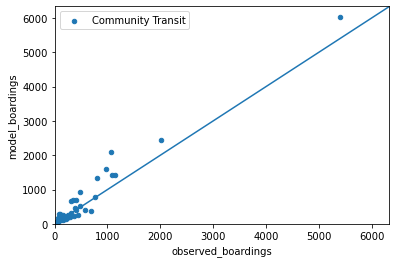

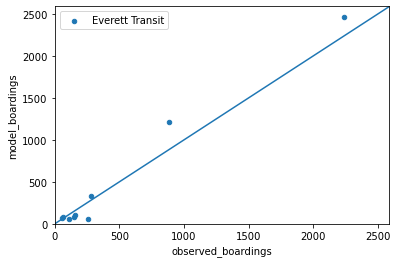

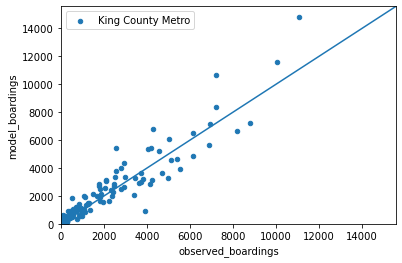

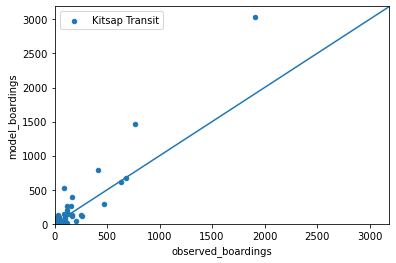

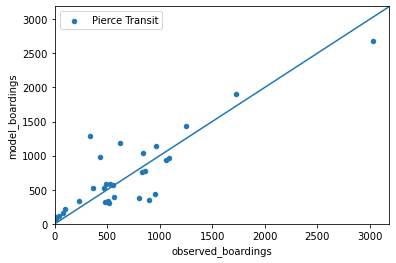

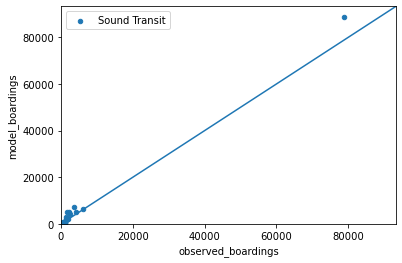

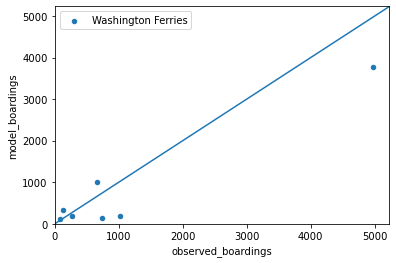

In [25]:
#| layout-ncol: 2
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [26]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

line_1_station_list = ['Northgate Station','Roosevelt Station','University District Station', 
                'Husky Stadium', 'Capitol Hill', 'Westlake', 'Symphony', 'Pioneer Square',
                "Int'l District",  'Stadium', 'SODO', 'Beacon Hill',
               'Mount Baker', 'Columbia City', 'Othello', 'Rainier Beach',
                "Tukwila Int'l Blvd", 'SeaTac/Airport', 'Angle Lake']
t_line_station_list = ['Tacoma Dome Station', 'S 25th St Station', 'Union Station',
       'Convention Center Station', 'Commerce Station']

In [27]:
line_1_df = df_table.loc[line_1_station_list]
line_1_df

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Northgate Station,"10,384.00","9,288.10","-1,095.90",-10.55%
Roosevelt Station,"4,349.00","9,125.12","4,776.12",109.82%
University District Station,"7,563.00","7,778.87",215.87,2.85%
Husky Stadium,"6,134.00","4,145.48","-1,988.52",-32.42%
Capitol Hill,"7,667.00","8,801.07","1,134.07",14.79%
Westlake,"8,845.00","11,631.44","2,786.44",31.50%
Symphony,"4,324.00","6,731.68","2,407.68",55.68%
Pioneer Square,"2,400.00","5,235.38","2,835.38",118.14%
Int'l District,"4,399.00","1,950.14","-2,448.86",-55.67%


In [28]:
fig = px.line(line_1_df[['observed_boardings','model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

In [29]:
t_line_df = df_table.loc[t_line_station_list]
t_line_df

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Tacoma Dome Station,494.00,269.68,-224.32,-45.41%
S 25th St Station,120.00,497.04,377.04,314.20%
Union Station,420.00,248.85,-171.15,-40.75%
Convention Center Station,91.00,692.01,601.01,660.45%
Commerce Station,294.00,495.13,201.13,68.41%


In [30]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/Symphony'
df_combined.loc[['Symphony'],'station_group'] = 'Westlake/Symphony'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined.loc[['University District Station'],'station_group'] = 'U District/Husky Stadium'
df_combined.loc[['Husky Stadium'],'station_group'] = 'U District/Husky Stadium'

df_combined.loc[['Northgate Station'],'station_group'] = 'Northgate/Roosevelt'
df_combined.loc[['Roosevelt Station'],'station_group'] = 'Northgate/Roosevelt'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined = df_combined.loc[['Northgate/Roosevelt','U District/Husky Stadium','Capitol Hill','Westlake/Symphony',"Pioneer Square/Int'l District",
                             'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                             "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]
df_combined

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Northgate/Roosevelt,"14,733.00","18,413.22","3,680.22",24.98%
U District/Husky Stadium,"13,697.00","11,924.35","-1,772.65",-12.94%
Capitol Hill,"7,667.00","8,801.07","1,134.07",14.79%
Westlake/Symphony,"13,169.00","18,363.11","5,194.11",39.44%
Pioneer Square/Int'l District,"6,799.00","7,185.53",386.53,5.69%
Stadium/SODO,"3,400.00","2,839.61",-560.39,-16.48%
Beacon Hill/Mount Baker,"4,008.00","3,151.89",-856.11,-21.36%
Columbia City,"1,630.00","1,820.37",190.37,11.68%
Othello/Rainier Beach,"3,525.00","4,099.69",574.69,16.30%


In [31]:

fig = px.line(df_combined[['observed_boardings','model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

In [32]:
df_obs = pd.read_sql(
    "SELECT * FROM light_rail_station_boardings WHERE year IN (2023, 2024)",
    con=conn,
)
df_obs.rename(columns={"boardings": "observed_boardings"}, inplace=True)

# df_obs.groupby(['year','station_name']).sum()
df_obs = pd.pivot_table(df_obs, values='observed_boardings', columns='year', index='station_name', aggfunc=np.sum)
df_obs = df_obs.fillna(0)
df_obs

df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name', usecols=['station_name','model_boardings'])
df = df.merge(df_obs,  left_index=True, right_index=True, how='outer')
df = df[df.index != 'Total']
df = df[~df['model_boardings'].isnull()]
df = df.loc[line_1_station_list]

In [33]:
fig = px.line(df[[2023,2024,'model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

## light rail stop transfers

In [34]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df.loc[line_1_station_list]

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Northgate Station,0.54,-99.00,99.54,-100.55%
Roosevelt Station,0.37,-99.00,99.37,-100.37%
University District Station,0.21,-99.00,99.21,-100.22%
Husky Stadium,0.81,-99.00,99.81,-100.82%
Capitol Hill,0.05,-99.00,99.05,-100.05%
Westlake,0.11,0.36,-0.25,-69.05%
Symphony,0.29,0.20,0.09,46.83%
Pioneer Square,0.36,0.16,0.20,125.77%
Int'l District,0.52,0.45,0.07,15.02%


## Park and Ride

In [35]:
df_trip = pd.read_csv(os.path.join(valid_config['model_dir'], 'outputs/daysim/_trip.tsv'), sep='\t')
pnr_boardings = df_trip[(df_trip['otaz'].isin(range(3750,4001))) & (df_trip['mode']==6)]
pnr_boardings = pnr_boardings.groupby('otaz').count()[['trexpfac']].reset_index()

In [36]:
stations = [
    {"id": 3751, "name": "Tukwila Station (CR)"},
    {"id": 3752, "name": "Tacoma Dome Station"},
    {"id": 3753, "name": "South Tacoma (CR)"},
    {"id": 3754, "name": "Everett Station (CR)"},
    {"id": 3755, "name": "Sumner Station (CR)"},
    {"id": 3756, "name": "Mukilteo Station"},
    {"id": 3757, "name": "Kent Station (CR)"},
    {"id": 3758, "name": "Auburn Station (CR)"},
    {"id": 3759, "name": "Lakewood (CR)"},
    {"id": 3760, "name": "Gateway P&R"},
    {"id": 3761, "name": "Puyallup Station (SB)"},
    {"id": 3762, "name": "Twin Lakes P&R"},
    {"id": 3763, "name": "Crossroads Neighborhood Church"},
    {"id": 3764, "name": "Overlake Transit Center"},
    {"id": 3765, "name": "Redondo Heights P&R"},
    {"id": 3766, "name": "North Gig Harbor/Kimball Drive"},
    {"id": 3767, "name": "Duvall P&R"},
    {"id": 3768, "name": "Roy 'Y' P&R"},
    {"id": 3769, "name": "South Hill (Elim Evangelical)"},
    {"id": 3770, "name": "Parkland Transit Center"},
    {"id": 3771, "name": "SR-512/I-5 (Lakewood)"},
    {"id": 3772, "name": "Center Street P&R"},
    {"id": 3773, "name": "Tacoma Mall Transit Center"},
    {"id": 3774, "name": "South Tacoma West"},
    {"id": 3775, "name": "South Tacoma East - 2"},
    {"id": 3776, "name": "Narrows P&R"},
    {"id": 3777, "name": "North Purdy/Purdy Crescent"},
    {"id": 3778, "name": "Point Defiance Ferry"},
    {"id": 3779, "name": "South Federal P&R"},
    {"id": 3780, "name": "Sultan P&R"},
    {"id": 3781, "name": "Federal Way P&R (320th)"},
    {"id": 3782, "name": "Auburn P&R"},
    {"id": 3783, "name": "Star Lake P&R"},
    {"id": 3784, "name": "Holy Spirit Lutheran Church"},
    {"id": 3785, "name": "Kent/Des Moines P&R"},
    {"id": 3786, "name": "Kent/James St. P&R"},
    {"id": 3787, "name": "Burien Transit Center"},
    {"id": 3788, "name": "Tukwila"},
    {"id": 3789, "name": "Maple Valley P&R"},
    {"id": 3790, "name": "South Renton P&R"},
    {"id": 3791, "name": "Renton Highlands P&R (St. Matts)"},
    {"id": 3792, "name": "Issaquah Transit Center"},
    {"id": 3793, "name": "Mercer Island P&R"},
    {"id": 3794, "name": "Mercer Island Presbyterian"},
    {"id": 3795, "name": "Newport Hills P&R"},
    {"id": 3796, "name": "Newport Hills Community Church"},
    {"id": 3797, "name": "Newport Covenant Church"},
    {"id": 3798, "name": "South Bellevue P&R"},
    {"id": 3799, "name": "Wilburton"},
    {"id": 3800, "name": "Eastgate P&R"},
    {"id": 3801, "name": "North Bend P&R"},
    {"id": 3802, "name": "Evergreen Point P&R"},
    {"id": 3803, "name": "Grace Lutheran Church"},
    {"id": 3804, "name": "South Kirkland P&R"},
    {"id": 3805, "name": "Overlake P&R"},
    {"id": 3806, "name": "Houghton P&R"},
    {"id": 3807, "name": "Bethel Lutheran"},
    {"id": 3808, "name": "Redmond P&R"},
    {"id": 3809, "name": "Saint Thomas Episcopal"},
    {"id": 3810, "name": "Valley Center"},
    {"id": 3811, "name": "Bear Creek P&R"},
    {"id": 3812, "name": "Kingsgate P&R"},
    {"id": 3813, "name": "Brickyard P&R"},
    {"id": 3814, "name": "Northshore P&R"},
    {"id": 3815, "name": "Kenmore P&R"},
    {"id": 3816, "name": "Bethany Bible Church"},
    {"id": 3817, "name": "Bothell P&R"},
    {"id": 3818, "name": "Woodinville P&R"},
    {"id": 3819, "name": "Olson & Meyers"},
    {"id": 3820, "name": "Spokane Street P&R"},
    {"id": 3821, "name": "Greenlake P&R"},
    {"id": 3822, "name": "Northgate TC"},
    {"id": 3823, "name": "North Jackson Park"},
    {"id": 3824, "name": "Shoreline"},
    {"id": 3825, "name": "112th St. & I-5"},
    {"id": 3826, "name": "Ober Park"},
    {"id": 3827, "name": "Vashon Heights"},
    {"id": 3828, "name": "Mountlake Terrace P&R"},
    {"id": 3829, "name": "Bethesda Lutheran"},
    {"id": 3830, "name": "Edmonds Station"},
    {"id": 3831, "name": "Edmonds P&R"},
    {"id": 3832, "name": "Lynnwood P&R"},
    {"id": 3833, "name": "Swamp Creek P&R"},
    {"id": 3834, "name": "Mariner P&R"},
    {"id": 3835, "name": "Snohomish"},
    {"id": 3836, "name": "Marysville - Ash Ave"},
    {"id": 3837, "name": "116th & I-5 - Marysville"},
    {"id": 3838, "name": "SR-531 - Marysville"},
    {"id": 3839, "name": "Arlington P&R"},
    {"id": 3840, "name": "Stanwood"},
    {"id": 3841, "name": "Monroe"},
    {"id": 3842, "name": "Federal Way"},
    {"id": 3843, "name": "Port Orchard Armory"},
    {"id": 3844, "name": "Southworth Ferry P&R"},
    {"id": 3845, "name": "McWilliams P&R"},
    {"id": 3846, "name": "Bethany Lutheran Church"},
    {"id": 3847, "name": "Gateway Fellowship"},
    {"id": 3848, "name": "Agate Pass P&R/Clearwater"},
    {"id": 3849, "name": "Kingston Ferry P&R"},
    {"id": 3850, "name": "Suquamish United Church of Christ"},
    {"id": 3851, "name": "Bainbridge Island Ferry"},
    {"id": 3852, "name": "Puyallup Station (NB)"},
    {"id": 3853, "name": "72nd Street Transit Center"},
    {"id": 3855, "name": "DuPont"},
    {"id": 3856, "name": "Aurora Village TC"},
    {"id": 3857, "name": "Aurora Nazarene"},
    {"id": 3858, "name": "Saint Margaret's Episcopal"},
    {"id": 3861, "name": "Lake Meridian P&R"},
    {"id": 3862, "name": "Smokey Pt. Church"},
    {"id": 3863, "name": "Eastmont P&R"},
    {"id": 3864, "name": "McCollum Park P&R"},
    {"id": 3865, "name": "Canyon Park P&R"},
    {"id": 3866, "name": "Korean Presby. P&R"},
    {"id": 3867, "name": "Georges Kountry Korner"},
    {"id": 3868, "name": "Poulsbo Church of the Nazarene"},
    {"id": 3870, "name": "Harper Evangelical Free Church"},
    {"id": 3871, "name": "Mullenix Road"},
    {"id": 3873, "name": "TCC P&R"},
    {"id": 3874, "name": "Ash Way P&R"},
    {"id": 3875, "name": "Bonney Lake P&R"},
    {"id": 3876, "name": "Tukwila Int. Station"},
    {"id": 3877, "name": "South Hill P&R"},
    {"id": 3878, "name": "South Tacoma East - 1"},
    {"id": 3879, "name": "Issaquah Highlands"},
    {"id": 3880, "name": "Lake Stevens TC"},
    {"id": 3881, "name": "Liberty Bay Presbyterian"},
    {"id": 3882, "name": "NK Baptist"},
    {"id": 3883, "name": "Preston P&R"},
    {"id": 3884, "name": "Bayside Community Church"},
    {"id": 3885, "name": "Ollala Valley Fire Station"},
    {"id": 3886, "name": "Bremerton Ferry"},
    {"id": 3888, "name": "Puyallup Fair's Red Lot"},
    {"id": 3889, "name": "Marysville - Cedar & Grove"},
    {"id": 3890, "name": "Stanwood II"},
    {"id": 3891, "name": "Marysville I P&R"},
    {"id": 3892, "name": "Martha Lake Covenant Church"},
    {"id": 3893, "name": "South Sammammish P&R"},
    {"id": 3894, "name": "Renton City Municipal Garage"},
    {"id": 3895, "name": "Tibbetts Lot"},
    {"id": 3896, "name": "Renton Transit Center"},
    {"id": 3897, "name": "Calvary Christian Assembly"},
    {"id": 3898, "name": "Maple Valley Town Square"},
    {"id": 3899, "name": "All Saints Lutheran Church"},
    {"id": 3900, "name": "City View Church"},
    {"id": 3901, "name": "Northwest University 6710 Bldg."},
    {"id": 3902, "name": "Sammamish Lutheran P&R"},
    {"id": 3903, "name": "Redmond Ridge P&R"},
    {"id": 3904, "name": "Kennydale United Methodist Church"},
    {"id": 3905, "name": "Nativity Lutheran Church"},
    {"id": 3906, "name": "South Jackson P&R"},
    {"id": 3907, "name": "South SeaTac (LR)"},
    {"id": 3908, "name": "Everett Station"},
    {"id": 3909, "name": "Bremerton (SR-303/Riddell Road)"},
    {"id": 3910, "name": "Silverdale"},
    {"id": 3911, "name": "Tukwila Station (CR)"},
    {"id": 3913, "name": "Sumner Station Garage"},
    {"id": 3914, "name": "Tacoma Dome"},
    {"id": 3915, "name": "Bothell (SR-527/185th Street)"},
    {"id": 3916, "name": "SR-3/SR-303"},
    {"id": 3917, "name": "SR-16/SR-160"},
    {"id": 3918, "name": "I-5 & 175th"}
]

In [37]:
pnr_capacity = pd.read_csv(os.path.join(valid_config['model_dir'], 'inputs/scenario/networks/p_r_nodes.csv'))
df = pnr_capacity.merge(pnr_boardings, left_on='ZoneID', right_on='otaz')
df.rename(columns={'ZoneID': 'taz', 'trexpfac': 'Model Boardings'}, inplace=True)
df['Boardings/Capacity'] = df['Model Boardings']/df['Capacity']
# df.head()

In [38]:
df_station_names = pd.DataFrame(stations)
df = df.merge(df_station_names, how='left', left_on='taz', right_on='id')

In [39]:
df['color'] = np.where(df['Boardings/Capacity'] > 1, 'Boardings/Capacity > 1', 'Boardings/Capacity <= 1')

fig = px.scatter(df, y='Model Boardings', x='Capacity', title='Model Boardings vs Capacity',
                 hover_data={'name': True, 'Model Boardings': True, 'Capacity': True, 'Boardings/Capacity': ':.2f'},
                 color='color')
fig.update_layout(height=600, width=800)
fig.show()

In [40]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.XCoord, df.YCoord), crs='EPSG:2285')
gdf.to_crs('EPSG:4326', inplace=True)

fig = px.scatter_mapbox(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x, color='Boardings/Capacity', 
                        size='Boardings/Capacity', hover_data=['name','taz','Model Boardings', 'Capacity'], 
                        title='Park and Ride Usage vs Capacity', zoom=8)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [41]:
# get observed data
p_r_observe_data = pd.read_csv("R:/e2projects_two/2023_base_year/park_and_ride/Park_and_Ride_observed_data_2023.csv")
# filter to latest data record for each park and ride (only 2021 and later years)
idx = p_r_observe_data.groupby(['lot_name'])['data_year'].transform(max) == p_r_observe_data['data_year']
df_p_r_observe_data = p_r_observe_data[idx].copy()
df_p_r_observe_data = df_p_r_observe_data.loc[df_p_r_observe_data['data_year']>=2021].copy()

# add station names to node file
df_p_r_nodes = pnr_capacity.merge(pd.DataFrame(stations), left_on="ZoneID", right_on="id")

# transform to geodataframe
gdf_p_r_nodes = gpd.GeoDataFrame(
    df_p_r_nodes, geometry=gpd.points_from_xy(df_p_r_nodes.XCoord, df_p_r_nodes.YCoord), crs="EPSG:2285"
)

gdf_p_r_observe_data = gpd.GeoDataFrame(
    df_p_r_observe_data, geometry=gpd.points_from_xy(df_p_r_observe_data.x_coord, df_p_r_observe_data.y_coord), crs="EPSG:2285"
)

# merge with park and ride name
gdf_p_r_data_name = gdf_p_r_nodes.merge(gdf_p_r_observe_data[['data_year', 'lot_name', 'lot_address', 'city','capacity', 'occupancy']],
                                        left_on="name",right_on="lot_name")

# merge by nearest location
gdf_p_r_data_near = gpd.sjoin_nearest(gdf_p_r_nodes.loc[~(gdf_p_r_nodes["name"].isin(gdf_p_r_data_name.name))],
                                      gdf_p_r_observe_data[['data_year', 'lot_name', 'lot_address', 'city','capacity', 'occupancy', 'geometry']],
                                      max_distance=500)

df_col = ['NodeID', 'ZoneID', 'data_year', 'name', 
          'lot_name', 'lot_address', 'city', 'Capacity', 'capacity', 'occupancy', 
          'XCoord', 'YCoord', 'geometry']
gdf_p_r_data = pd.concat([gdf_p_r_data_name[df_col],gdf_p_r_data_near[df_col]]).copy()

# merge boardings
gdf_p_r_data = gdf_p_r_data.merge(pnr_boardings, left_on="ZoneID", right_on="otaz")

gdf_p_r_data = gdf_p_r_data[['NodeID', 'ZoneID', 'data_year', 'name', 'lot_name', 'lot_address',
       'city', 'Capacity', 'capacity', 'occupancy', 'trexpfac', 'XCoord', 'YCoord',
       'geometry']].copy().rename(columns={'trexpfac':'boardings'})

gdf_p_r_data['boardings - occupancy'] = gdf_p_r_data['boardings'] - gdf_p_r_data['occupancy']
gdf_p_r_data['percent diff'] = gdf_p_r_data['boardings - occupancy'] / gdf_p_r_data['occupancy']

gdf_p_r_data.to_crs('EPSG:4326', inplace=True)


In [42]:
fig = px.scatter_mapbox(gdf_p_r_data, lat=gdf_p_r_data.geometry.y, lon=gdf_p_r_data.geometry.x, color='percent diff', 
                        hover_data=['name','ZoneID','boardings', 'Capacity', 'boardings - occupancy'], 
                        title='Park and Ride Usage vs Observed Data', zoom=8)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [43]:
gdf_p_r_data[['ZoneID', 'data_year', 'name','city', 'capacity', 'occupancy', 'boardings', 'boardings - occupancy', 'percent diff']].sort_values(['city','name'])

,ZoneID,data_year,name,city,capacity,occupancy,boardings,boardings - occupancy,percent diff
35,3839,2023,Arlington P&R,Arlington,25,5,4,-1,-0.20
102,3862,2023,Smokey Pt. Church,Arlington,50,13,4,-9,-0.69
50,3899,2023,All Saints Lutheran Church,Auburn,75,20,6,-14,-0.70
9,3782,2023,Auburn P&R,Auburn,244,53,4,-49,-0.92
60,3758,2023,Auburn Station (CR),Auburn,520,295,533,238,0.81
...,...,...,...,...,...,...,...,...,...
110,3876,2023,Tukwila Int. Station,Tukwila,600,570,342,-228,-0.40
55,3751,2023,Tukwila Station (CR),Tukwila,390,133,96,-37,-0.28
31,3826,2023,Ober Park,Vashon Island,48,7,1,-6,-0.86
25,3810,2023,Valley Center,Vashon Island,55,4,3,-1,-0.25


# Transit Submodes by Purpose
Model Outputs Only (insufficient samples available from survey)

In [44]:
import h5py
myh5 = h5py.File(r'..\..\..\..\inputs\scenario\landuse\hh_and_persons.h5', 'r')
person = pd.read_csv(r'..\..\..\..\outputs\daysim\_person.tsv', sep='\t')

In [45]:
# Create a DataFrame from the h5 file
df_person = pd.DataFrame()
for col in ['hhno','pno','prace']:
    df_person[col] = myh5['Person'][col][:]

df_trip = df_trip.merge(df_person[['hhno','pno','prace']], on=['hhno','pno'], how='left')

In [46]:
# Create group of work, school, and all other purposes
df_trip['Purpose Type'] = 'Other'
df_trip.loc[df_trip['dpurp']==0, 'Purpose Type'] = 'Home'
df_trip.loc[df_trip['dpurp']==1, 'Purpose Type'] = 'Work'
df_trip.loc[df_trip['dpurp']==2, 'Purpose Type'] = 'School'

# Rename path types
df_trip.loc[df_trip['pathtype']==1, 'Path Type'] = 'Drive'
df_trip.loc[df_trip['pathtype']==3, 'Path Type'] = 'Bus'
df_trip.loc[df_trip['pathtype']==4, 'Path Type'] = 'Light Rail'
df_trip.loc[df_trip['pathtype']==5, 'Path Type'] = 'Ferry 1'
df_trip.loc[df_trip['pathtype']==6, 'Path Type'] = 'Commuter Rail'
df_trip.loc[df_trip['pathtype']==7, 'Path Type'] = 'Ferry 2'

df = pd.pivot_table(df_trip[(df_trip['dpurp']!=0) & (df_trip['pathtype']!=0)], values='trexpfac', index='Path Type', columns='Purpose Type', aggfunc=np.sum)

df['Total'] = df.sum(axis=1)
for row in df.index:
    for col in ['Work','School','Other']:
        df.loc[row, col + ' %'] = df.loc[row, col] / df.loc[row, 'Total']

df[['Work %','School %','Other %']] = df[['Work %','School %','Other %']].applymap("{:,.1%}".format)
df[['Work %','School %','Other %']]

Purpose Type,Work %,School %,Other %
Path Type,,,
Bus,15.1%,10.5%,74.4%
Commuter Rail,50.1%,1.9%,48.0%
Drive,19.7%,5.5%,74.8%
Ferry 1,42.5%,12.2%,45.4%
Ferry 2,61.6%,1.5%,36.9%
Light Rail,33.0%,9.8%,57.3%


#### Transit Submodes by Person Race

In [47]:

race_dict = {
    '1': 'White alone',
    '2': 'Black or African American alone',
    '3': 'American Indian alone',
    '4': 'Alaska Native alone',
    '5': 'American Indian and Alaska Native tribes specified',
    '6': 'Asian alone',
    '7': 'Native Hawaiian and Other Pacific Islander alone',
    '8': 'Some Other Race alone',
    '9': 'Two or More Races'
}


df_trip['Race'] = df_trip['prace'].astype('int').astype('str').map(race_dict)

In [48]:
# Submode Ridership by race
df = pd.pivot_table(df_trip[(df_trip['pathtype']!=0)], values='trexpfac', index='Path Type', columns='Race', aggfunc=np.sum)
race_cols = ['White alone','Black or African American alone','American Indian alone',
             'Alaska Native alone','American Indian and Alaska Native tribes specified','Asian alone',
             'Native Hawaiian and Other Pacific Islander alone','Some Other Race alone','Two or More Races']
# Calculate shares of total by Race for each Path Type
df['Total'] = df.sum(axis=1)
for row in df.index:
    for col in race_cols:
        df.loc[row, col] = df.loc[row, col] / df.loc[row, 'Total']
df[race_cols] = df[race_cols].applymap("{:,.1%}".format)

In [49]:
df[race_cols]

Race,White alone,Black or African American alone,American Indian alone,Alaska Native alone,American Indian and Alaska Native tribes specified,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Two or More Races
Path Type,,,,,,,,,
Bus,59.6%,7.6%,0.6%,0.1%,0.1%,18.5%,0.7%,3.9%,8.9%
Commuter Rail,63.9%,7.2%,0.9%,0.1%,0.1%,11.2%,1.8%,5.4%,9.5%
Drive,64.7%,5.5%,0.6%,0.1%,0.1%,14.8%,1.0%,4.3%,8.9%
Ferry 1,79.3%,2.1%,0.6%,nan%,0.1%,6.2%,2.0%,2.2%,7.5%
Ferry 2,82.0%,2.3%,0.7%,0.1%,0.1%,4.3%,0.8%,2.5%,7.2%
Light Rail,57.9%,8.5%,0.6%,0.1%,0.1%,20.3%,0.6%,3.7%,8.3%
